In [1]:
!pip install gensim --upgrade
!pip install keras --upgrade
!pip install pandas --upgrade

Requirement already up-to-date: gensim in c:\users\s164937\anaconda3\lib\site-packages (3.8.3)
Requirement already up-to-date: keras in c:\users\s164937\anaconda3\lib\site-packages (2.4.3)
Requirement already up-to-date: pandas in c:\users\s164937\anaconda3\lib\site-packages (1.1.3)


In [2]:
!pip install pip --upgrade

Requirement already up-to-date: pip in c:\users\s164937\anaconda3\lib\site-packages (20.2.4)


In [3]:
!pip install --user virtualenv

^C


In [4]:
!pip install tensorflow

^C


In [22]:
# DataFrame
import pandas as pd

# Matplot
import matplotlib.pyplot as plt
%matplotlib inline

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer

# Keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM
from keras import utils
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

# nltk
import nltk
from nltk.corpus import stopwords
from  nltk.stem import SnowballStemmer

# Word2vec
import gensim

# Utility
import re
import numpy as np
import os
from collections import Counter
import logging
import time
import pickle
import itertools

#load

from numpy import loadtxt
from keras.models import load_model

# Set log
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [3]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\s164937\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [4]:
# DATASET
DATASET_COLUMNS = ["target", "ids", "date", "flag", "user", "text"]
DATASET_ENCODING = "ISO-8859-1"
TRAIN_SIZE = 0.8

# TEXT CLENAING
TEXT_CLEANING_RE = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

# WORD2VEC 
W2V_SIZE = 300
W2V_WINDOW = 7
W2V_EPOCH = 32
W2V_MIN_COUNT = 10

# KERAS
SEQUENCE_LENGTH = 300
EPOCHS = 8
BATCH_SIZE = 1024

# SENTIMENT
POSITIVE = "POSITIVE"
NEGATIVE = "NEGATIVE"
NEUTRAL = "NEUTRAL"
SENTIMENT_THRESHOLDS = (0.4, 0.7)

# EXPORT
KERAS_MODEL = "model.h5"
WORD2VEC_MODEL = "model.w2v"
TOKENIZER_MODEL = "tokenizer.pkl"
ENCODER_MODEL = "encoder.pkl"

Read Dataset

In [5]:
dataset_filename = os.listdir("../input")[0]
dataset_path = os.path.join("..","input",dataset_filename)
print("Open file:", dataset_path)
df = pd.read_csv(dataset_path, encoding =DATASET_ENCODING , names=DATASET_COLUMNS)

Open file: ..\input\training.1600000.processed.noemoticon.csv


In [9]:
print("Dataset size:", len(df))

Dataset size: 1600000


In [6]:
df.head(5)

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


Map target label to String

In [7]:
decode_map = {0: "NEGATIVE", 2: "NEUTRAL", 4: "POSITIVE"}
def decode_sentiment(label):
    return decode_map[int(label)]

In [8]:
%%time
df.target = df.target.apply(lambda x: decode_sentiment(x))

Wall time: 1.12 s


Text(0.5, 1.0, 'Dataset labels distribuition')

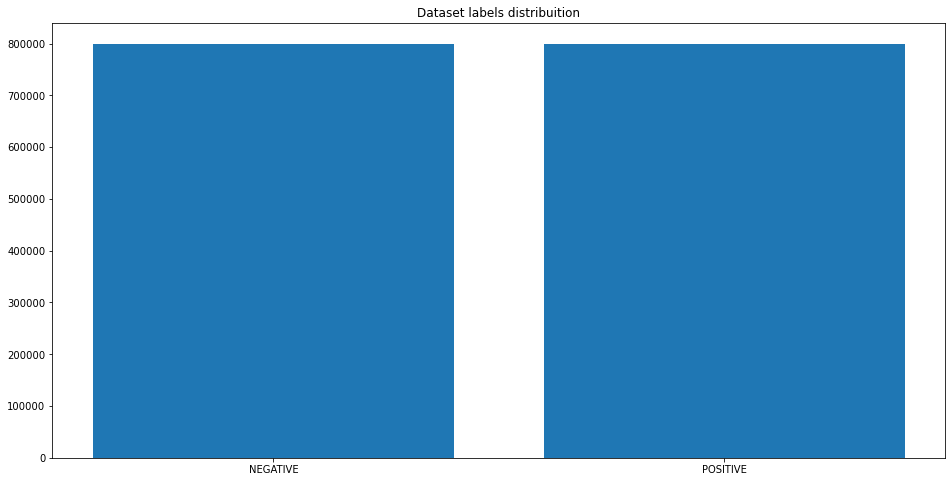

In [9]:
target_cnt = Counter(df.target)

plt.figure(figsize=(16,8))
plt.bar(target_cnt.keys(), target_cnt.values())
plt.title("Dataset labels distribuition")

Pre-Process dataset

In [10]:
stop_words = stopwords.words("english")
stemmer = SnowballStemmer("english")

In [11]:
def preprocess(text, stem=False):
    # Remove link,user and special characters
    text = re.sub(TEXT_CLEANING_RE, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)

In [12]:
%%time
df.text = df.text.apply(lambda x: preprocess(x))

Wall time: 2min 30s


In [13]:
df_train, df_test = train_test_split(df, test_size=1-TRAIN_SIZE, random_state=42)
print("TRAIN size:", len(df_train))
print("TEST size:", len(df_test))

TRAIN size: 1280000
TEST size: 320000


Word2Vec

In [14]:
%%time
documents = [_text.split() for _text in df_train.text] 

Wall time: 14.6 s


In [15]:
w2v_model = gensim.models.word2vec.Word2Vec(size=W2V_SIZE, 
                                            window=W2V_WINDOW, 
                                            min_count=W2V_MIN_COUNT, 
                                            workers=8)

In [16]:
w2v_model.build_vocab(documents)

2020-10-30 13:57:13,729 : INFO : collecting all words and their counts
2020-10-30 13:57:13,732 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2020-10-30 13:57:13,834 : INFO : PROGRESS: at sentence #10000, processed 72565 words, keeping 14005 word types
2020-10-30 13:57:13,971 : INFO : PROGRESS: at sentence #20000, processed 144393 words, keeping 21587 word types
2020-10-30 13:57:14,224 : INFO : PROGRESS: at sentence #30000, processed 215826 words, keeping 27541 word types
2020-10-30 13:57:14,417 : INFO : PROGRESS: at sentence #40000, processed 288271 words, keeping 32764 word types
2020-10-30 13:57:14,581 : INFO : PROGRESS: at sentence #50000, processed 359772 words, keeping 37587 word types
2020-10-30 13:57:14,725 : INFO : PROGRESS: at sentence #60000, processed 431431 words, keeping 42198 word types
2020-10-30 13:57:14,881 : INFO : PROGRESS: at sentence #70000, processed 503103 words, keeping 46458 word types
2020-10-30 13:57:15,017 : INFO : PROGRESS: at s

In [17]:
words = w2v_model.wv.vocab.keys()
vocab_size = len(words)
print("Vocab size", vocab_size)

Vocab size 30369


In [18]:
%%time
w2v_model.train(documents, total_examples=len(documents), epochs=W2V_EPOCH)

2020-10-30 13:58:25,582 : INFO : training model with 8 workers on 30369 vocabulary and 300 features, using sg=0 hs=0 sample=0.001 negative=5 window=7
2020-10-30 13:58:26,687 : INFO : EPOCH 1 - PROGRESS: at 1.95% examples, 150716 words/s, in_qsize 15, out_qsize 0
2020-10-30 13:58:27,693 : INFO : EPOCH 1 - PROGRESS: at 5.22% examples, 206523 words/s, in_qsize 14, out_qsize 0
2020-10-30 13:58:28,725 : INFO : EPOCH 1 - PROGRESS: at 8.26% examples, 218306 words/s, in_qsize 15, out_qsize 0
2020-10-30 13:58:29,738 : INFO : EPOCH 1 - PROGRESS: at 11.30% examples, 225194 words/s, in_qsize 15, out_qsize 0
2020-10-30 13:58:30,740 : INFO : EPOCH 1 - PROGRESS: at 14.32% examples, 229775 words/s, in_qsize 14, out_qsize 0
2020-10-30 13:58:31,742 : INFO : EPOCH 1 - PROGRESS: at 17.13% examples, 229981 words/s, in_qsize 15, out_qsize 2
2020-10-30 13:58:32,797 : INFO : EPOCH 1 - PROGRESS: at 20.38% examples, 233419 words/s, in_qsize 16, out_qsize 0
2020-10-30 13:58:33,811 : INFO : EPOCH 1 - PROGRESS: at

KeyboardInterrupt: 

In [19]:
w2v_model = pickle.load(open("model.w2v", 'rb'))

In [20]:
w2v_model.most_similar("love")

<ipython-input-20-9e1a4c826e7b>:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  w2v_model.most_similar("love")
2020-10-30 13:59:59,764 : INFO : precomputing L2-norms of word weight vectors


[('luv', 0.5732780694961548),
 ('loves', 0.5623786449432373),
 ('loved', 0.5373271703720093),
 ('amazing', 0.5026600360870361),
 ('adore', 0.4942743182182312),
 ('looove', 0.47235167026519775),
 ('awesome', 0.4598265290260315),
 ('lovee', 0.45823755860328674),
 ('loveee', 0.4531649351119995),
 ('loooove', 0.442605197429657)]

Tokenize text

In [ ]:
%%time
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train.text)

vocab_size = len(tokenizer.word_index) + 1
print("Total words", vocab_size)

In [ ]:
%%time
x_train = pad_sequences(tokenizer.texts_to_sequences(df_train.text), maxlen=SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(df_test.text), maxlen=SEQUENCE_LENGTH)

Label Encoder

In [ ]:
labels = df_train.target.unique().tolist()
labels.append(NEUTRAL)
labels

In [ ]:
encoder = LabelEncoder()
encoder.fit(df_train.target.tolist())

y_train = encoder.transform(df_train.target.tolist())
y_test = encoder.transform(df_test.target.tolist())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train",y_train.shape)
print("y_test",y_test.shape)

In [ ]:
print("x_train", x_train.shape)
print("y_train", y_train.shape)
print()
print("x_test", x_test.shape)
print("y_test", y_test.shape)

In [ ]:
y_train[:10]

Embedding Layer

In [ ]:
embedding_matrix = np.zeros((vocab_size, W2V_SIZE))
for word, i in tokenizer.word_index.items():
  if word in w2v_model.wv:
    embedding_matrix[i] = w2v_model.wv[word]
print(embedding_matrix.shape)

In [ ]:
embedding_layer = Embedding(vocab_size, W2V_SIZE, weights=[embedding_matrix], input_length=SEQUENCE_LENGTH, trainable=False)

Build model

In [ ]:
model = Sequential()
model.add(embedding_layer)
model.add(Dropout(0.5))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

model.summary()

Compile model

In [ ]:
model.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

Callbacks

In [ ]:
callbacks = [ ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              EarlyStopping(monitor='val_acc', min_delta=1e-4, patience=5)]

Load

In [24]:
modelw = pickle.load(open("model.w2v", 'rb'))
tokenizer = pickle.load(open("tokenizer.pkl", "rb"))
encoder = pickle.load(open("encoder.pkl", "rb"))

C:\Users\s164937\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.preprocessing.label module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.preprocessing. Anything that cannot be imported from sklearn.preprocessing is now part of the private API.
  warnings.warn(message, FutureWarning)
C:\Users\s164937\Anaconda3\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator LabelEncoder from version 0.20.1 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(


In [23]:
modelh = load_model('model.h5')

In [26]:
%%time
score = modelh.evaluate(x_test, y_test, batch_size=BATCH_SIZE)
print()
print("ACCURACY:",score[1])
print("LOSS:",score[0])

NameError: name 'x_test' is not defined

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

In [27]:
def decode_sentiment(score, include_neutral=True):
    if include_neutral:        
        label = NEUTRAL
        if score <= SENTIMENT_THRESHOLDS[0]:
            label = NEGATIVE
        elif score >= SENTIMENT_THRESHOLDS[1]:
            label = POSITIVE

        return label
    else:
        return NEGATIVE if score < 0.5 else POSITIVE

In [30]:
def predict(text, include_neutral=True):
    start_at = time.time()
    # Tokenize text
    x_test = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen=SEQUENCE_LENGTH)
    # Predict
    score = modelh.predict([x_test])[0]
    # Decode sentiment
    label = decode_sentiment(score, include_neutral=include_neutral)

    return {"label": label, "score": float(score),
       "elapsed_time": time.time()-start_at}  

In [37]:
predict("Finish fast")

{'label': 'NEGATIVE',
 'score': 0.22640293836593628,
 'elapsed_time': 0.1934833526611328}